# Reviewer response data
In this notebook I am runnning the code that Jordan has requested. Specifically, I am using an updated dataset that contains external variables.

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, precision_recall_fscore_support
import sklearn
from sklearn.model_selection import train_test_split
import pickle

In [2]:
africa = pd.read_csv('../Data/africa-ML-02-08-2022.csv')
africa = africa.dropna('columns')
africa=sklearn.utils.shuffle(africa)
labels = africa['sahoStatusEHA']
data = africa.drop(columns=['sahoStatusEHA', 'country', 'christCountry', 'cumCasesLag1',
                        'cumCasesLag1P100KC', 'cumDeathsLag1', 'ebolaCasesN', 'gdpPerCap', 'medDocsN',
                        #'revZmuslimPct', 'revZurbanPop', 'revZnonComDis', 'revZtempDiffSunfitted','ExternalFactor',
                        'ZExternalFactor',
                        'tempDiffS', 'tempDiff66', 'dayNum']
                   ).select_dtypes(['number'])
#Split into test and training
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.24, random_state=42, stratify=labels)


<ipython-input-2-e26a5994ca62>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  africa = africa.dropna('columns')


<ipython-input-3-d8ef65c45b4d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.hist(np.array([y_train, y_test]) , 3,  histtype='bar', label=['training', 'test'])


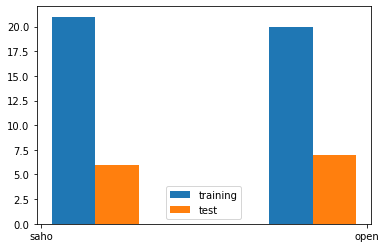

In [3]:
plt.hist(np.array([y_train, y_test]) , 3,  histtype='bar', label=['training', 'test'])
plt.legend()

In [4]:
feature_importance = {}
for i in np.arange(1000):
    rf = RandomForestClassifier(n_estimators = 50, max_depth=30, criterion='entropy', n_jobs=2)
    rf.fit(X_train, y_train)
    # predictions = rf.predict(X_test)
    # Collect 10 most important features
    importance = pd.DataFrame({'feature': X_train.columns, 'importance': np.round(rf.feature_importances_, 3)})
    importance.sort_values('importance', ascending=False, inplace=True)
    importance = importance[:50]
    # Assign values to dictionary
    for imp in importance.values:
        if imp[0] not in feature_importance.keys():
            # If the key is not already there then add it
            feature_importance[imp[0]] = [imp[1]]
        else:
            feature_importance[imp[0]].append(imp[1])

In [5]:
feature_importance_df = pd.DataFrame.from_dict(feature_importance, orient='index')
final_features = feature_importance_df.agg(['mean', 'std', 'sem'], axis=1).sort_values('mean', ascending=False)[:30]
final_features['95-conf'] = 1.96*final_features['sem']
final_features['99-conf'] = 3*final_features['sem']
pickle.dump(final_features, open('final_features.pkl','wb'))
print(final_features[:10])

                       mean       std       sem   95-conf   99-conf
tempDiffSunfitted  0.060824  0.018352  0.000580  0.001137  0.001741
prevAdopt          0.035321  0.013292  0.000421  0.000826  0.001264
ZSocialFactor      0.030125  0.011925  0.000380  0.000745  0.001140
casesMD            0.029411  0.011207  0.000357  0.000699  0.001070
SGGENPARLZS        0.022133  0.009182  0.000299  0.000587  0.000898
ZDFactor1          0.021503  0.009023  0.000300  0.000588  0.000900
ICREGDURS          0.021132  0.008451  0.000277  0.000542  0.000830
urbanPop           0.021043  0.008640  0.000288  0.000564  0.000863
muslimPct          0.020510  0.008056  0.000264  0.000517  0.000792
ITNETUSERZS        0.019292  0.007732  0.000262  0.000513  0.000785


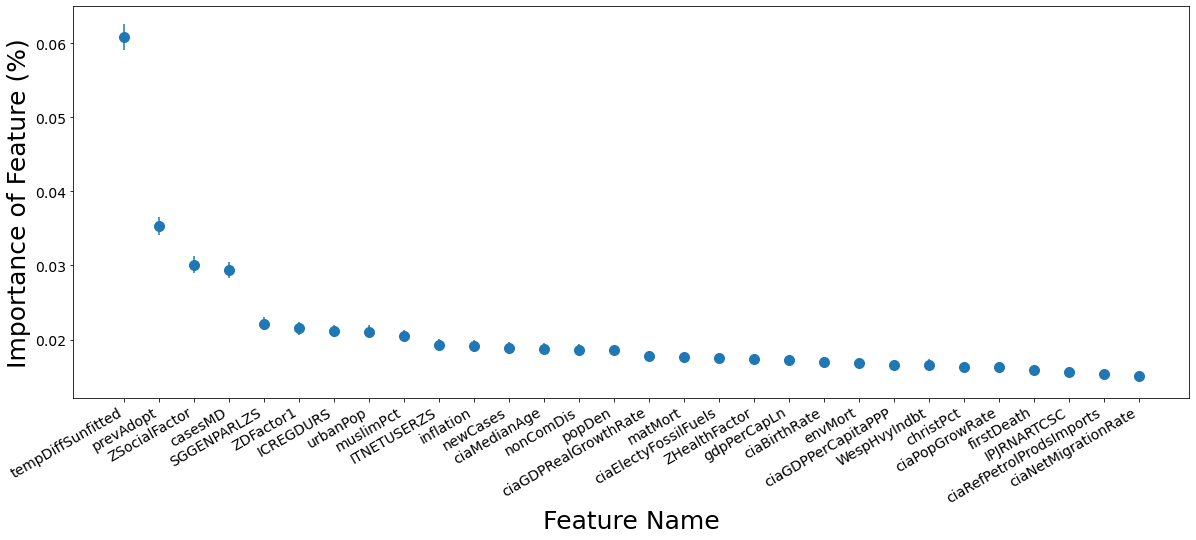

In [6]:
#with plt.xkcd():
fig = plt.figure(figsize=(20,8))
plt.errorbar(final_features.index, 'mean', yerr='99-conf', data=final_features, fmt='o', ms=10)
#plt.xticks(rotation=-60)
fig.autofmt_xdate()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Feature Name', fontsize=25)
plt.ylabel('Importance of Feature (%)', fontsize=25)
plt.savefig('../Plots/Reviewer/Feature-Importance.png')

## F1-score weighted average as a function of the number of parameters kept
We will use 5, 10, 15, 20, 25, and 30 parameters while recording the weighted average f1-score.feature_importance

In [7]:
final_features_ordered = final_features.to_dict()
print(final_features_ordered['mean'].keys())

dict_keys(['tempDiffSunfitted', 'prevAdopt', 'ZSocialFactor', 'casesMD', 'SGGENPARLZS', 'ZDFactor1', 'ICREGDURS', 'urbanPop', 'muslimPct', 'ITNETUSERZS', 'inflation', 'newCases', 'ciaMedianAge', 'nonComDis', 'popDen', 'ciaGDPRealGrowthRate', 'matMort', 'ciaElectyFossilFuels', 'ZHealthFactor', 'gdpPerCapLn', 'ciaBirthRate', 'envMort', 'ciaGDPPerCapitaPPP', 'WespHvyIndbt', 'christPct', 'ciaPopGrowRate', 'firstDeath', 'IPJRNARTCSC', 'ciaRefPetrolProdsImports', 'ciaNetMigrationRate'])


In [8]:
f1_scores = {}
for num in [1,5,10,15,20,25,30]:
    final_used_features = list(final_features_ordered['mean'].keys())[:num]
    print(final_used_features)
    for i in range(1000): 
        rf = RandomForestClassifier(n_estimators = 50, max_depth=30, criterion='entropy')  # Define classifier
        rf.fit(X_train[final_used_features], y_train)  # Fit 
        predictions = rf.predict(X_test[final_used_features])  # Predict
        f1_weighted_avg = list(precision_recall_fscore_support(y_test, predictions, average='weighted'))[2]  # Record f1 weighted avg
    if num not in f1_scores.keys():
        f1_scores[num] = [f1_weighted_avg]
    else:
        f1_scores[num].append(f1_weighted_avg)
    #print(classification_report(y_test, predictions, labels=list(set(y_test))))

['tempDiffSunfitted']


KeyboardInterrupt: 

In [ ]:
f1_scores

{1: [0.6923076923076923],
 5: [0.6107226107226107],
 10: [0.6807692307692308],
 15: [0.8403846153846154],
 20: [0.8403846153846154],
 25: [0.7511312217194571],
 30: [0.6923076923076923]}